In [47]:
#Part 1: 我们在此先生成了每个点的运动历史，即序列ηk，其中共4097个点，6000步历史，先固定alpha，随后再通过改变alpha的值检测其方差与
#t^(2H)

using StatsBase
using HypothesisTests
using Distributions

x_min = -2048    #2048
x_max = 2048     #2048
theta = 10                                # 质量幂次参数，我们依次取0，1/2，1，2，10，无穷
num_steps = 2000                          #分别考虑100，200……2000步，步差为100，
num_steps_history = 6000                  #ηk的长度
num_points = x_max - x_min + 1            #点的个数
#point_history = []                       #ηk的记录
alpha =  1/6                              #α的取值
H = alpha + 1/2                           #Hurst Coefficient

#我们先一次性取出10^8个随机数
A = rand(10^8)
#B = rand(10^8)
#println(mean(A))
#println(var(A))
#println(length(A))

# 优化：预分配Yita和History，避免push!
Yita = Vector{Vector{Float64}}(undef, num_points)
History = Vector{Vector{Int}}(undef, num_points)

# 定义函数g
function g(x)
    return (1 - x)^(-1 / alpha) - 1
end

# 优化：可选多线程并行（需Julia支持多线程）
Threads.@threads for i in 1:num_points
    choosed_random_numbers = A[(i-1)*num_steps_history + 1 : i*num_steps_history]
    Yita[i] = choosed_random_numbers

    Random_History = choosed_random_numbers
    history_each_point = Vector{Int}(undef, num_steps_history)
    for j in 1:num_steps_history
        x = Random_History[j]
        result = g(x)
        result = ceil(result)
        if result > num_steps_history
            index = -1
        else
            result = Int(result)
            index = j - result
        end
        if index <= 0
            random_walk = rand([-1, 1])
        else
            random_walk = history_each_point[index]
        end
        history_each_point[j] = random_walk
    end
    History[i] = history_each_point
end

#检测一下
#println(length(Yita))
#println(length(History[10]))


#println(History[10])
#综上我们成功定义了所需要的ηk序列并且将其保存在了History数组中以便调用
#下面我们将考虑如何对点的随机游走进行处理

In [48]:
#Part 2 ：对于每个点，先进行一定规则的随机游走，再判断点的运动状态以及吸收态，
B = rand(10^8)  # 生成一个包含10^8个随机数的数组
# 定义结构体
struct Point
    coords::Vector{Int}   # 点的坐标
    i::Int                # 点的索引，对点就行标号，判断点的吸收态
    j::Int                # 点被哪个点所吸收,点的吸收态
    k::Int                # 点的质量
    t::Int                # 0 为可以移动，1 为不能移动
    history::Vector{Int}  # 点的历史，存为一个数组
end

# 初始化所有点
function init_points(x_min, x_max, motion_history)
    points = [Point([2i, 0], i, i, 1, 0, motion_history[i - x_min + 1]) for i in x_min:x_max]
    return points
end

# 初始化轨迹
function init_trajectories(points, x_min)
    trajectories = [Vector{Vector{Int}}() for _ in points]
    for (index, point) in enumerate(points)
        idx = point.i - x_min + 1
        push!(trajectories[idx], point.coords)
    end
    return trajectories
end

# 构建可移动点的坐标字典
function build_coord_dict(points)
    coord_dict = Dict{Tuple{Int,Int}, Int}()
    for (idx, p) in enumerate(points)
        if p.t == 0
            coord_dict[(p.coords[1], p.coords[2])] = idx
        end
    end
    return coord_dict
end

# 生成本步所有可动点的随机数
function get_random_numbers(B, num_movable)
    random_numbers = splice!(B, 1:num_movable)
    return random_numbers
end

# 计算本步所有可动点的结果
function get_results(random_numbers, alpha)
    results = map(η -> (1 - η) ^ (-1 / alpha) - 1, random_numbers)
    results = ceil.(results)
    return results
end

# 单步模拟
function simulate_step!(points, trajectories, B, alpha, theta, num_steps, num_steps_history, x_min)
    coord_dict = build_coord_dict(points)
    movable_points = filter(p -> p.t == 0, points)
    num_movable = length(movable_points)
    random_numbers = get_random_numbers(B, num_movable)
    results = get_results(random_numbers, alpha)

    for (index, point) in enumerate(movable_points)
        coord_dict = build_coord_dict(points)
        global_idx = findfirst(p -> p.i == point.i, points)
        if points[global_idx].t == 1
            continue
        end
        if point.t == 0
            movable_index = findfirst(p -> p.i == point.i, movable_points)
            if movable_index !== nothing
                result = results[movable_index]
                if result > num_steps + num_steps_history
                    random_change = rand([-1, 1])
                else
                    result = Int(result)
                    if length(point.history) - result <= 0
                        random_change = rand([-1, 1])
                    else
                        random_change = point.history[length(point.history) - result]
                    end
                end
            end

            new_history = copy(point.history)
            push!(new_history, random_change)
            new_coords = copy(point.coords)
            new_coords[1] += random_change
            new_coords[2] += 1

            new_point = Point(new_coords, point.i, point.j, point.k, 0, new_history)
            global_idx = findfirst(p -> p.i == point.i, points)
            points[global_idx] = new_point

            new_coord_tuple = (new_coords[1], new_coords[2])
            merged = false
            if  haskey(coord_dict, new_coord_tuple)
                target_idx = coord_dict[new_coord_tuple]
                if points[target_idx].i != point.i && points[target_idx].t == 0
                    m1 = new_point.k
                    m2 = points[target_idx].k
                    prob = m1^theta / (m1^theta + m2^theta)
                    if  rand() < prob   # 此时我们更新点的吸收态，即点的j值以及t值
                        points[global_idx] = Point(points[global_idx].coords, points[global_idx].i, points[global_idx].j, m1 + m2, 0, points[global_idx].history)
                        points[target_idx] = Point(points[target_idx].coords, points[target_idx].i, points[global_idx].j, m1 + m2, 1, points[target_idx].history)
                        merged = true
                    else                # another condition
                        points[target_idx] = Point(points[target_idx].coords, points[target_idx].i, points[target_idx].j, m1 + m2, 0, points[target_idx].history)
                        points[global_idx] = Point(points[global_idx].coords, points[global_idx].i, points[target_idx].j, m1 + m2, 1, points[global_idx].history)
                        merged = true
                    end
                    # 合并后立即更新coord_dict，确保t值最新
                    coord_dict = build_coord_dict(points)
                    # 合并后也push最后一次坐标
                    idx = point.i - x_min + 1
                    push!(trajectories[idx], new_point.coords)
                    continue
                end
            end

            # 只要点还没被合并（t=0），就持续push
            if points[global_idx].t == 0 && !merged
                idx = point.i - x_min + 1
                push!(trajectories[idx], new_point.coords)
            end
        end
    end
end

# 主模拟函数
function run_simulation!(points, trajectories, B, alpha, theta, num_steps, num_steps_history, x_min)
    for step in 1:num_steps
        simulate_step!(points, trajectories, B, alpha, theta, num_steps, num_steps_history, x_min)
    end
end

# ========== 主流程调用 ===========
points = init_points(x_min, x_max, History)
trajectories = init_trajectories(points, x_min)
run_simulation!(points, trajectories, B, alpha, theta, num_steps, num_steps_history, x_min)




In [49]:
#Part 3: 数据操作和统计分析
using Test
#以上完成了模拟，
#下面进行一定的数据操作
for step in 100:100:num_steps
    # 统计每个点在step步时的横坐标和初始横坐标
    coord_map = Dict{Int, Tuple{Int, Int, Int}}()  # key: x坐标, value: (idx, t, origin)
    for (idx, traj) in enumerate(trajectories)
        if length(traj) >= step
            x = traj[step][1]
            origin = traj[1][1]
            tval = points[idx].t
            if haskey(coord_map, x)
                # 若有重叠，保留t=0的，删除t=1的
                old_idx, old_t, old_origin = coord_map[x]
                if old_t == 1 && tval == 0
                    coord_map[x] = (idx, tval, origin)
                elseif old_t == 0 && tval == 1
                    # reserve the original
                elseif old_t == 0 && tval == 0
                    # 都可动，任选其一（默认保留原有）
                elseif old_t == 1 && tval == 1
                    # 都不可动，任选其一（默认保留原有）
                end
            else
                coord_map[x] = (idx, tval, origin)
            end
        end
    end
    # 按照x_coords从小到大排序
    sorted_keys = sort(collect(keys(coord_map)))
    x_coords = sorted_keys
    origins = [coord_map[k][3] for k in sorted_keys]
    @assert length(x_coords) == length(origins) "Length mismatch: coords_diff and origins should be the same length"
    println("Step $step: x_coords = $x_coords")
    println("Step $step: origins = $origins")

    # 计算每个点的位移
    Displacement = [x_coords[i]- origins[i] for i in 1:length(x_coords)]
    println("Step $step: Displacement = $Displacement")
    @assert length(Displacement) == length(origins) "Length mismatch: Displacement and origins should be the same length"

    # 计算每个点的质量
    masses = [points[coord_map[x][1]].j for x in sorted_keys]
    println("Step $step: masses = $masses")
    @assert length(masses) == length(origins) "Length mismatch: masses and origins should be the same length"

    # 计算吸收态相关的最大i值差距
    coords_diff = []
    for origin_index in origins
        k_idx = findfirst(x -> x.j == origin_index, points)
        m_idx = findlast(x -> x.j == origin_index, points)

        if k_idx !== nothing && m_idx !== nothing
            coord_diff = abs(points[k_idx].i - points[m_idx].i)
            push!(coords_diff, coord_diff)
        #else
            # 如果没找到，设为0或跳过，视需求而定
            #push!(coords_diff, 0)  # 或者 continue
        end
    end
    println("Step $step: coords_diff = $coords_diff")
    println(length(coords_diff))
    # 检查coords_diff和origins的长度是否一致
    #@assert length(origins) == length( coords_diff), "Length mismatch: coords_diff and origins should be the same length"

end




Step 100: x_coords = [-4099, -4071, -4037, -4017, -4003, -3987, -3975, -3947, -3927, -3901, -3863, -3839, -3829, -3799, -3767, -3719, -3713, -3691, -3657, -3655, -3607, -3565, -3527, -3501, -3467, -3437, -3397, -3389, -3379, -3343, -3337, -3305, -3265, -3245, -3211, -3191, -3171, -3155, -3113, -3089, -3039, -3023, -3011, -2969, -2957, -2933, -2899, -2869, -2851, -2819, -2809, -2769, -2733, -2701, -2695, -2691, -2683, -2659, -2607, -2575, -2553, -2533, -2505, -2497, -2461, -2421, -2413, -2377, -2367, -2343, -2331, -2303, -2277, -2243, -2211, -2185, -2159, -2147, -2123, -2119, -2093, -2073, -2057, -2023, -1979, -1947, -1895, -1861, -1857, -1825, -1797, -1765, -1739, -1693, -1681, -1677, -1669, -1645, -1597, -1577, -1551, -1539, -1527, -1491, -1451, -1419, -1411, -1375, -1327, -1251, -1199, -1173, -1157, -1143, -1113, -1101, -1081, -1051, -1021, -987, -965, -937, -923, -899, -865, -837, -809, -777, -765, -719, -703, -669, -653, -627, -589, -581, -551, -543, -527, -515, -487, -475, -457, -

以上完成了对点的历史的定义

以下是对于点的轨迹的检测

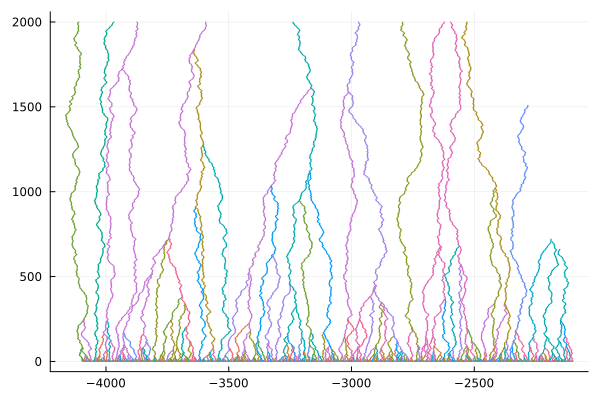

In [51]:
using Plots

function plot_trajectories(trajectories)
    p = plot()  # 创建一个新的图形
    # 只遍历前100个点的轨迹
    for i in 1:min(1000, length(trajectories))
        traj = trajectories[i]
        if !isempty(traj)
            x_coords = [coord[1] for coord in traj]
            y_coords = [coord[2] for coord in traj]
            plot!(p, x_coords, y_coords, legend=false)
        end
    end
    display(p)  # 显示图形
end

# 假设trajectories是之前模拟生成的轨迹数组
plot_trajectories(trajectories)

In [ ]:
# 对全部模拟过程进行500遍，每次的数据储存到一个文件中
using Serialization

for run_id in 1:500
    # 重新初始化
    points = init_points(x_min, x_max, History)
    trajectories = init_trajectories(points, x_min)
    B = rand(10^8)
    run_simulation!(points, trajectories, B, alpha, theta, num_steps, num_steps_history, x_min)

    # 收集每个step的x_coords和origins，结构为 Dict{Int, Tuple{Vector{Int}, Vector{Int}}}
    step_data = Dict{Int, Tuple{Vector{Int}, Vector{Int}}}()
    for step in 100:100:num_steps
        coord_map = Dict{Int, Tuple{Int, Int, Int}}()
        for (idx, traj) in enumerate(trajectories)
            if length(traj) >= step
                x = traj[step][1]
                origin = traj[1][1]
                tval = points[idx].t
                if haskey(coord_map, x)
                    old_idx, old_t, old_origin = coord_map[x]
                    if old_t == 1 && tval == 0
                        coord_map[x] = (idx, tval, origin)
                    elseif old_t == 0 && tval == 1
                        # 保持原有
                    end
                else
                    coord_map[x] = (idx, tval, origin)
                end
            end
        end
        x_coords = [k for k in keys(coord_map)]
        origins = [v[3] for v in values(coord_map)]
        step_data[step] = (x_coords, origins)
    end

    # 保存到文件
    filename = "simulation_run_$(run_id).jls"
    open(filename, "w") do io
        serialize(io, step_data)
    end
end